In [1]:

!pip install ucimlrepo --quiet
!pip install xgboost --quiet

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer  # <--- Importante
import numpy as np
import os
from multiprocessing import Pool
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc


# 1. Carregar dados
ozone = fetch_ucirepo(id=172) 
X = ozone.data.features.to_numpy()
y = ozone.data.targets.to_numpy().ravel() # Use .ravel() para evitar avisos de formato

# 2. TRATAR NaNs (Imputação)
# Vamos preencher os NaNs com a média de cada coluna
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# 3. Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Função para treinar (mantida como a sua)
def treinar_modelo(i):
    smote = SMOTE(random_state=i)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    xgb = XGBClassifier(random_state=i)
    xgb.fit(X_res, y_res)
    return xgb

def criar_ensemble(n_modelos):
    n_processos = os.cpu_count()
    with Pool(processes=n_processos) as pool:
        modelos = pool.map(treinar_modelo, range(n_modelos))
    return modelos

# Criar os modelos
modelos = criar_ensemble(6)

# 4. Predição Otimizada
# Em vez de prever um por um, prevemos o bloco todo de uma vez
def prever_ensemble(X_data):
    # Coleta predições de todos os modelos: shape (n_modelos, n_amostras)
    todas_preds = np.array([model.predict(X_data) for model in modelos])
    # Tira a média das predições e aplica o limiar de 0.5
    return (np.mean(todas_preds, axis=0) > 0.5).astype(int)

y_pred = prever_ensemble(X_test)

# Avaliação
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

F1 Score: 0.5287


In [2]:

# 1. Relatório Completo (Precision, Recall e F1 para cada classe)
print("Relatório de Classificação Completo:")
print(classification_report(y_test, y_pred))

# 2. Apenas os valores específicos para a classe 1 (Minoritaria)
prec = precision_score(y_test, y_pred, pos_label=1)
rec = recall_score(y_test, y_pred, pos_label=1)

print("-" * 30)
print(f"Métricas da Classe Minoritária (Classe 1):")
print(f"Precisão: {prec:.2f}")
print(f"Recall:    {rec:.2f}")

Relatório de Classificação Completo:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       975
           1       0.48      0.59      0.53        39

    accuracy                           0.96      1014
   macro avg       0.73      0.78      0.75      1014
weighted avg       0.96      0.96      0.96      1014

------------------------------
Métricas da Classe Minoritária (Classe 1):
Precisão: 0.48
Recall:    0.59


In [3]:
def prever_probabilidades_ensemble(X_data):
    # Coleta a probabilidade da classe 1 para cada modelo
    # model.predict_proba retorna [prob_classe_0, prob_classe_1]
    todas_probs = np.array([model.predict_proba(X_data)[:, 1] for model in modelos])
    # Tira a média das probabilidades de todos os modelos
    return np.mean(todas_probs, axis=0)

# Obtendo as probabilidades para o conjunto de teste
y_probs = prever_probabilidades_ensemble(X_test)

# 2. Calculando a PR AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc_score = auc(recall, precision)

print(f"PR AUC (Área sob a Curva Precision-Recall): {pr_auc_score:.2f}")

PR AUC (Área sob a Curva Precision-Recall): 0.53


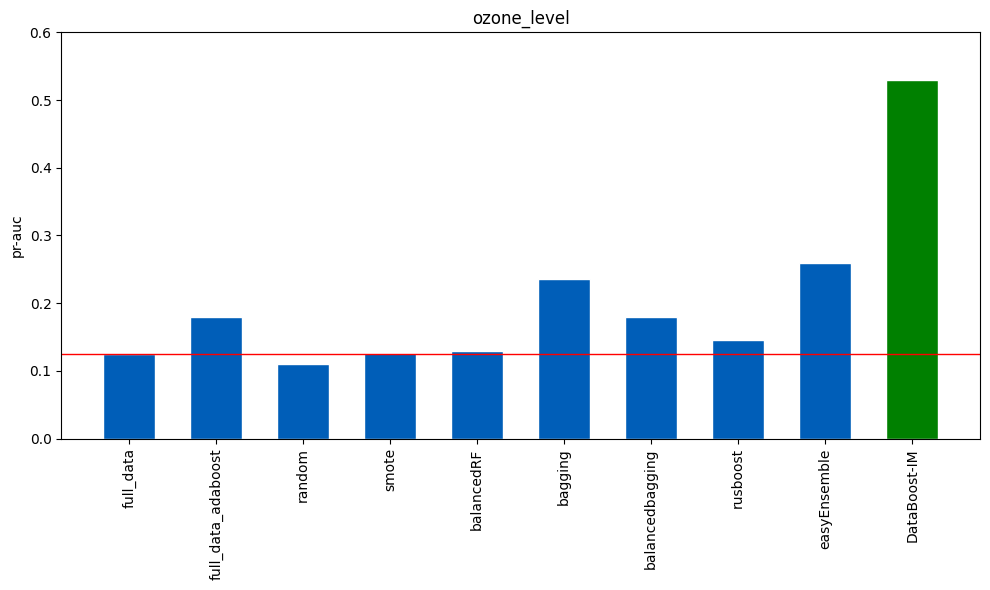

In [4]:
import matplotlib.pyplot as plt

# 1. Dados extraídos da imagem + Nova barra 'X'
labels = [
    'full_data', 'full_data_adaboost', 'random', 'smote', 
    'balancedRF', 'bagging', 'balancedbagging', 'rusboost', 
    'easyEnsemble', 'DataBoost-IM'  # Rótulo adicionado
]

# Valores aproximados com base na escala da imagem
valores = [
    0.125, 0.18, 0.11, 0.126, 
    0.13, 0.235, 0.18, 0.145, 
    0.26, 0.53   # Valor exemplo para a barra X
]

# 2. Configuração das cores
# Criamos uma lista de cores onde todas são azuis, exceto a última que é verde
cores = ['#005eb8'] * (len(labels) - 1) + ['green']

# 3. Criação do gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, valores, color=cores, edgecolor='white', width=0.6)

# 4. Adicionar a linha horizontal vermelha (referência do full_data)
plt.axhline(y=0.125, color='red', linestyle='-', linewidth=1)

# 5. Formatação estética
plt.title('ozone_level')
plt.ylabel('pr-auc')
plt.xticks(rotation=90) # Rotaciona os nomes para caberem no eixo
plt.ylim(0, 0.6)       # Ajusta o limite do eixo Y para a escala da imagem

# Ajusta o layout para não cortar os nomes embaixo
plt.tight_layout()

# Exibir o gráfico
plt.show()